In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import scipy.io.wavfile as sio
import scipy as sp
import matplotlib.pyplot as plt
from utils import vectorize
from utils import vectorize_teensy
import csv
tf.enable_eager_execution()

import numpy as np
import osa
import time

# Classification

In [2]:
##EXAMPLE 1
#PRE-PROCESSING AUDIO DATA
rate1 , audio1 = sio.read('Recorded_data/bus_stop2.wav')
rate2 , audio2 = sio.read('Recorded_data/construction_site2.wav')
rate3 , audio3 = sio.read('Recorded_data/park.wav')

#Each audio sample here is sampled at 16000hz, so they can all be combined into 1 long sample
rate = rate1
audio = np.hstack((audio1,audio2,audio3))


#Use vectorize function to fft, bin,average, and group data together
data = vectorize(audio,rate,1/4,group_size = 3,full = False, training = False, serial = False)

print(data.shape)
print(data[5000:5010])


/home/darnel/anaconda3/envs/myenv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(7209, 15)
[[0.04435842 0.01085751 0.01109341 0.0052776  0.00206843 0.04220006
  0.0101602  0.010917   0.00550243 0.00268411 0.04494159 0.00944559
  0.01116051 0.0060773  0.00255613]
 [0.04445665 0.00913013 0.0132573  0.00644049 0.00262946 0.03863393
  0.01063337 0.01448383 0.00633464 0.00254022 0.04780072 0.01023145
  0.01145729 0.00516622 0.00253884]
 [0.04164248 0.00956111 0.01095782 0.00481272 0.00251808 0.04380499
  0.0107489  0.01028956 0.00497183 0.00219364 0.0388629  0.0099243
  0.01175821 0.00528729 0.00237419]
 [0.03775052 0.01027642 0.01242716 0.00513994 0.00222339 0.05034025
  0.01023491 0.0115486  0.00490681 0.00243784 0.04383128 0.01072192
  0.01328359 0.00614233 0.00261424]
 [0.04557734 0.01053998 0.01451496 0.00592511 0.00255613 0.04212258
  0.0102107  0.01051716 0.00520912 0.00237696 0.03911125 0.00885135
  0.0114144  0.00527968 0.00261493]
 [0.04838805 0.00935358 0.01132031 0.00533848 0.00235967 0.04347225
  0.01040855 0.01149464 0.00523125 0.0025001  0.04754269 0.010

In [6]:
##Example 2
#PRE-PROCESSING TEENSY DATA

path = "test.csv" #path to csv file with pasted serial monitor fft data

data = vectorize_teensy(path)
print(data.shape)
print(data[0:10])


(33, 15)
[[0.21384615 0.05076923 0.02923077 0.02153846 0.01923077 0.15
  0.05538462 0.05076923 0.03461538 0.02615385 0.20384615 0.07230769
  0.02769231 0.02923077 0.03769231]
 [0.16230769 0.05       0.03461538 0.02923077 0.02538462 0.19230769
  0.04153846 0.02846154 0.03846154 0.03       0.13692308 0.03076923
  0.03307692 0.03076923 0.01923077]
 [0.17846154 0.06692308 0.03307692 0.03384615 0.02615385 0.13461538
  0.05923077 0.04       0.03692308 0.02538462 0.16692308 0.05230769
  0.03846154 0.04153846 0.04384615]
 [0.14692308 0.06307692 0.03923077 0.03692308 0.03923077 0.19923077
  0.05615385 0.02846154 0.03846154 0.03307692 0.15076923 0.05384615
  0.04153846 0.03       0.03692308]
 [0.13307692 0.03692308 0.03153846 0.02923077 0.03       0.18153846
  0.04769231 0.02769231 0.02769231 0.02384615 0.20230769 0.06076923
  0.02615385 0.02461538 0.02769231]
 [0.17615385 0.04846154 0.04538462 0.03076923 0.03384615 0.20076923
  0.07846154 0.03538462 0.03769231 0.02076923 0.18615385 0.06307692
 

In [6]:
#Setup current Model and load weights
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(9, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation=tf.nn.relu),  
  tf.keras.layers.Dense(2, activation=tf.nn.softmax),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Load weights
model.load_weights('./weights/my_model')

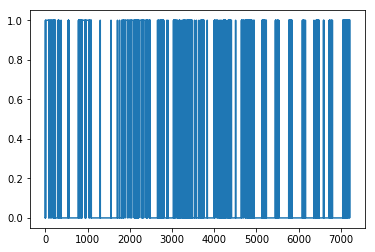

In [7]:
#Test and view predictions
predictions = model.predict(data)
#make and plot predictions
c = np.argmax(predictions,axis=1)
plt.plot(c)
plt.show()

# Training

In [2]:
#Data
#get wave_file and labels
rate1 , audio1 = sio.read('Recorded_data/bus_stop2.wav')
rate2 , audio2 = sio.read('Recorded_data/construction_site2.wav')
rate3 , audio3 = sio.read('Recorded_data/park.wav')

label1 = sp.io.loadmat('Recorded_data/bus_stop.mat')
label1 = label1['y_label']
label2 = sp.io.loadmat('Recorded_data/construction_site.mat')
label2 = label2['y_label']
label3 = sp.io.loadmat('Recorded_data/park.mat')
label3 = label3['y_label']


#Combine Audio and Labels
rate = rate1
audio = np.hstack((audio1,audio2,audio3))
labels = np.vstack((label1,label2,label3))

#Use vectorize function to fft, bin,average, and group data together
data, labels = vectorize(audio,rate,1/4,group_size = 3,full = False, training = True,labels = labels, serial = False)

print(data.shape)
print(labels.shape)
print(data[5000:5010])

/home/darnel/anaconda3/envs/myenv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(7209, 15)
(7209, 1)
[[0.04435842 0.01085751 0.01109341 0.0052776  0.00206843 0.04220006
  0.0101602  0.010917   0.00550243 0.00268411 0.04494159 0.00944559
  0.01116051 0.0060773  0.00255613]
 [0.04445665 0.00913013 0.0132573  0.00644049 0.00262946 0.03863393
  0.01063337 0.01448383 0.00633464 0.00254022 0.04780072 0.01023145
  0.01145729 0.00516622 0.00253884]
 [0.04164248 0.00956111 0.01095782 0.00481272 0.00251808 0.04380499
  0.0107489  0.01028956 0.00497183 0.00219364 0.0388629  0.0099243
  0.01175821 0.00528729 0.00237419]
 [0.03775052 0.01027642 0.01242716 0.00513994 0.00222339 0.05034025
  0.01023491 0.0115486  0.00490681 0.00243784 0.04383128 0.01072192
  0.01328359 0.00614233 0.00261424]
 [0.04557734 0.01053998 0.01451496 0.00592511 0.00255613 0.04212258
  0.0102107  0.01051716 0.00520912 0.00237696 0.03911125 0.00885135
  0.0114144  0.00527968 0.00261493]
 [0.04838805 0.00935358 0.01132031 0.00533848 0.00235967 0.04347225
  0.01040855 0.01149464 0.00523125 0.0025001  0.0475

In [3]:
#Define the model you want and train it here
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(9, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation=tf.nn.relu),  
  tf.keras.layers.Dense(2, activation=tf.nn.softmax),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data, labels, epochs=100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/100
7209/7209 [==============================] - 0s 43us/sample - loss: 0.6572 - acc: 0.6966
Epoch 2/100
7209/7209 [==============================] - 0s 29us/sample - loss: 0.5586 - acc: 0.7516
Epoch 3/100
7209/7209 [==============================] - 0s 27us/sample - loss: 0.4946 - acc: 0.7903
Epoch 4/100
7209/7209 [==============================] - 0s 42us/sample - loss: 0.4538 - acc: 0.8216
Epoch 5/100
7209/7209 [==============================] - 0s 41us/sample - loss: 0.4293 - acc: 0.8290
Epoch 6/100
7209/7209 [==============================] - 0s 44us/sample - loss: 0.4061 - acc: 0.8402
Epoch 7/100
7209/7209 [==============================] - 0s 40us/sample - loss: 0.3931 - acc: 0.8448
Epoch 8/100
7209/7209 [==============================] - 0s 35us/sample - loss: 0.3825 - acc: 0.8494
Epoch

In [5]:
#Save weights to a TensorFlow Checkpoint file
model.save_weights('./weights/my_model')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


2403/2403 [==============================] - 0s 117us/sample - loss: 0.1699 - acc: 0.9496

Test accuracy: 0.9496463


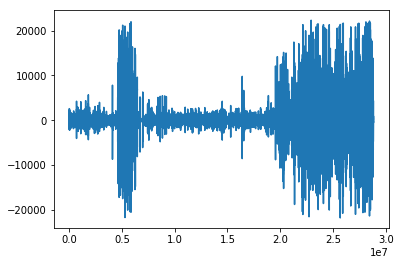

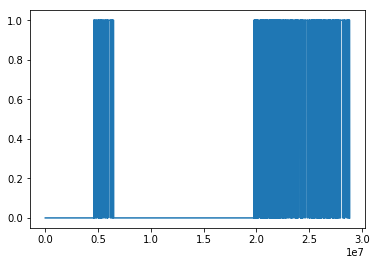

In [8]:
#Choose test data for evaluation
rate , audio = sio.read('Recorded_data/room.wav')
label = sp.io.loadmat('Recorded_data/room.mat')
label = label['y_label']

test_data, test_labels = vectorize(audio,rate,1/4,group_size = 3,full = False, training = True,labels = label, serial = False)




#test model accuracy
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('\nTest accuracy:', test_acc)


#visualize input
plt.plot(audio)
plt.show()
plt.plot(label)
plt.show()

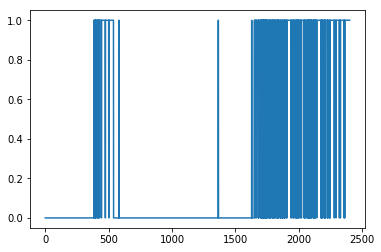

In [9]:
predictions = model.predict(test_data)
#make and plot predictions
c = np.argmax(predictions,axis=1)
plt.plot(c)
plt.show()